In [1]:
# Example of Tool Functionalities using some fake generated cell data

In [2]:
# 1. Import

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv as cv
import classes.data_prep as prep
import classes.gp as gp
import classes.data_visualisation as visualisation
import classes.optimisation as optimisation
import classes.gillespie as gillespie
import classes.model_selection as model_selection
from matplotlib.backends.backend_pdf import PdfPages

import warnings
warnings.filterwarnings('ignore')
# warnings.filterwarnings(action='once')

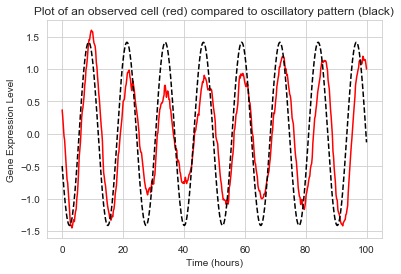

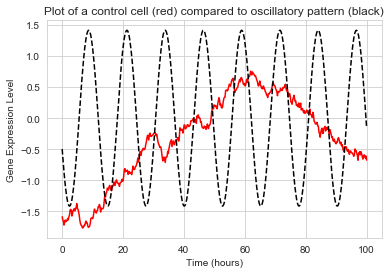

In [20]:
# 2. Generate Fake Data using the Prior GP Function

# To generate fake data for this example we could have also used Gillespie's Algorithm, Normalised and Detrended the data.
# However a much quicker way for this purpose is to use the Prior Gaussian Process function under the class GP() called
# generate_prior_ou_trace. This is useful to generate random samples from a gaussian process for which we can specify the
# true parameters. This will aid us in being able to determine whether the tool can approximate these true values well or not.

true_alpha = 0.005
true_beta = 0.5
true_variance = 1.0
true_noise = 1.0

# Creating observations, 10 oscillating cells.
observed_cells = gp.GP(alpha = true_alpha, beta = true_beta, variance = true_variance, noise = true_noise, oscillatory = True)
observed_cells = observed_cells.generate_prior_ou_trace(duration = 100, number_of_observations = 500, number_of_traces = 10)

# - - Plot of one observed cell generated with intention to show oscillatory pattern,
# hence compare to sinusoid wave.

# change sine wave starting position to approximate.
timepoints = np.linspace(0, 100, 500)
sinusoid_wave = np.sqrt(2)*np.sin(0.5*timepoints+3.5)

plt.plot(timepoints, observed_cells[:,1], color = 'red')
plt.plot(timepoints, sinusoid_wave, color = 'black', ls = "--")
plt.title("Plot of an observed cell (red) compared to oscillatory pattern (black)")
plt.xlabel("Time (hours)")
plt.ylabel("Gene Expression Level")
plt.show()

# - - 
# From this true signal made up of 500 points, we pick out only a 50 observations.

observation_id = np.arange(0, 500, 10) #50 observations
observed_cells = observed_cells[observation_id, :]

# Creating control data, 10 non-oscillating cells.
control_cells = gp.GP(alpha = true_alpha, beta = 0.0, variance = true_variance, noise = true_noise, oscillatory = False)
control_cells = control_cells.generate_prior_ou_trace(duration = 100, number_of_observations = 500, number_of_traces = 10)

# - - Plot of one control cell generated with intention to show non-oscillatory pattern,
# hence compare to sinusoid wave.

# change sine wave starting position to approximate.
timepoints = np.linspace(0, 100, 500)
sinusoid_wave = np.sqrt(2)*np.sin(0.5*timepoints+3.5)

plt.plot(timepoints, control_cells[:,1], color = 'red')
plt.plot(timepoints, sinusoid_wave, color = 'black', ls = "--")
plt.title("Plot of a control cell (red) compared to oscillatory pattern (black)")
plt.xlabel("Time (hours)")
plt.ylabel("Gene Expression Level")
plt.show()

# - - 

control_cells = control_cells[observation_id, :]

# Merge
observed_timepoints = observed_cells[:,0]
cells = np.hstack((observed_cells[:,1:11], control_cells[:,1:11]))

- - - Select some arbitrary parameters for the GP fit to observe an initial Prior and Posterior Fit - - -
Note, original parameters used to generate the observed cell are:
Alpha :  0.005 , Beta :  0.5 , Variance :  1.0 , Noise :  1.0
 -            -            -          -            -  
Input alpha : 0.2
Input beta : 0.5
Input variance : 1.0
Input noise : 0.0


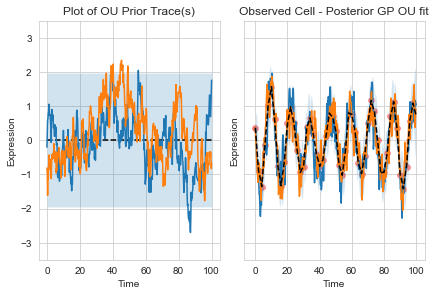

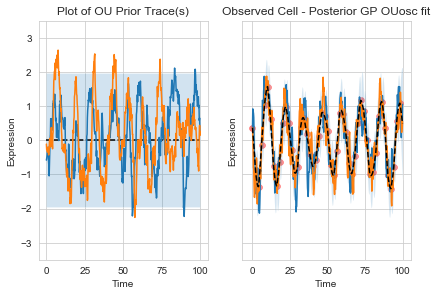

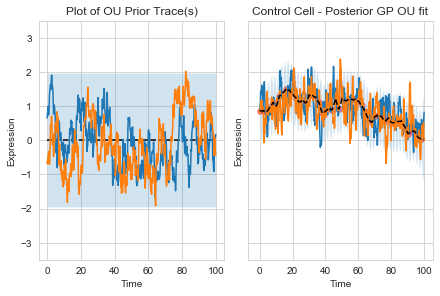

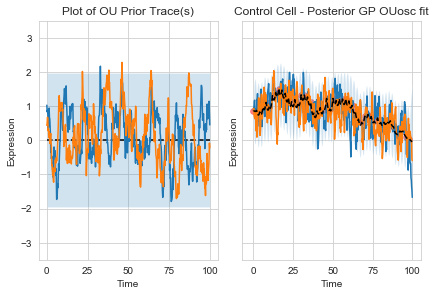

In [23]:
# 2. Initial Plot of GP Fit of one observed cell and one control cell for some arbitrary parameters.

# For a quick visualisation of an initial fit, the class Visualisation_GP() works well.
# All that is needed is an input of the parameters of choice.
# As optionals you can specify:
# - the time duration (in hours),
# - the number of fitted observations to produce,
# - the number of random traces to plot.

print("- - - Select some arbitrary parameters for the GP fit to observe an initial Prior and Posterior Fit - - -")
print("Note, original parameters used to generate the observed cell are:")
print("Alpha : ", true_alpha, ", Beta : ", true_beta, ", Variance : ", true_variance, ", Noise : ", true_noise)
print(" -            -            -          -            -  ")

alpha = float(input("Input alpha : "))
beta = float(input("Input beta : "))
variance = float(input("Input variance : "))
noise = float(input("Input noise : "))

# - - - - Observed Cell

GP_OU_fit_arbitrary_parameters = visualisation.Visualisation_GP(alpha = alpha, beta = beta, variance = variance, noise = noise, oscillatory = False, observed_timepoints = observed_timepoints, observed_y = cells[:,0], cholesky_decompose = True)
GP_OUosc_fit_arbitrary_parameters = visualisation.Visualisation_GP(alpha = alpha, beta = beta, variance = variance, noise = noise, oscillatory = True, observed_timepoints = observed_timepoints, observed_y = cells[:,0], cholesky_decompose = True)

# OU Model - Non Oscillatory Fit
GP_OU_fit_arbitrary_parameters.gp_ou_trace_subplot(duration = 100, number_of_observations = 500, number_of_traces = 2)[0]
plt.title("Observed Cell - Posterior GP OU fit")
plt.show()
# OUosc Model - Oscillatory Fit
GP_OUosc_fit_arbitrary_parameters.gp_ou_trace_subplot(duration = 100, number_of_observations = 500, number_of_traces = 2)[0]
plt.title("Observed Cell - Posterior GP OUosc fit")
plt.show()

# - - - - Control Cell

control_GP_OU_fit_arbitrary_parameters = visualisation.Visualisation_GP(alpha = alpha, beta = beta, variance = variance, noise = noise, oscillatory = False, observed_timepoints = observed_timepoints, observed_y = control_cells[:,1], cholesky_decompose = True)
control_GP_OUosc_fit_arbitrary_parameters = visualisation.Visualisation_GP(alpha = alpha, beta = beta, variance = variance, noise = noise, oscillatory = True, observed_timepoints = observed_timepoints, observed_y = control_cells[:,1], cholesky_decompose = True)

# OU Model - Non Oscillatory Fit
control_GP_OU_fit_arbitrary_parameters.gp_ou_trace_subplot(duration = 100, number_of_observations = 500, number_of_traces = 2)[0]
plt.title("Control Cell - Posterior GP OU fit")
plt.show()
# OUosc Model - Oscillatory Fit
control_GP_OUosc_fit_arbitrary_parameters.gp_ou_trace_subplot(duration = 100, number_of_observations = 500, number_of_traces = 2)[0]
plt.title("Control Cell - Posterior GP OUosc fit")
plt.show()

In [29]:
# 3. Hyper Parameter Estimation for one cell

# For a quick optimisation of a single cell, the class Optimisation() serves well.
# All that is needed is:
# - Specifying whether you are optimising an oscillatory or non-oscillatory signal.
#   Note : this will change the model optimised (OU or OUosc) since the covariance function is involved in the evaluation of the Log Marginal Likelihood.
# - Input of observed_timepoints and observed gene expression cell data.
# - Start values that you wish your optimisation to start from. Be careful of stumbling upon a local minima.
# As optionals you may change the optimisation method:
# I recommend checking out the documentation before making any changes to the methods and bounds used.

print("- - - Select starting parameter values to carry out an optimisation of the Log Marginal Likelihood - - -")
print("Note, original parameters used to generate the observed cell are:")
print("Alpha : ", true_alpha, ", Beta : ", true_beta, ", Variance : ", true_variance, ", Noise : ", true_noise)
print(" -            -            -          -            -  ")

start_alpha = float(input("Input starting value alpha : "))
start_beta = float(input("Input starting value beta : "))
start_variance = float(input("Input starting value variance : "))
start_noise = float(input("Input starting value noise : "))

# Observed Cell

observed_optim = optimisation.Optimisation(oscillatory = True, observed_timepoints = observed_timepoints, observed_y = cells[:,0])
observed_optim = observed_optim.optimizing_neg_marginal_loglikelihood_callback(start_values = [start_alpha, start_beta, start_variance, start_noise], method = 'L-BFGS-B', bounds = ((1e-10, None), (None, None), (1e-10, None), (1e-10, None)), cholesky_decompose = True, callback = True)

# Control Cell

control_optim = optimisation.Optimisation(oscillatory = True, observed_timepoints = observed_timepoints, observed_y = cells[:,0])

optim = observed_optim[0]
optim_results = observed_optim[0].x
print("- - - Comparing estimated parameters versus input ones for Oscillatory Model - - -")
print("- - - Results for Observed Cell - - -")
print("Estimated Alpha:", optim_results[0], " Input Alpha:", true_alpha)
print("Estimated Beta:", optim_results[1], " Input Beta:", true_beta)
print("Estimated Variance:", optim_results[2], " Input Variance:", true_variance)
print("Estimated Noise:", optim_results[3], " Input Noise:", true_noise)
print("- - - Results for Control Cell - - -")




- - - Select starting parameter values to carry out an optimisation of the Log Marginal Likelihood - - -
Note, original parameters used to generate the observed cell are:
Alpha :  0.005 , Beta :  0.5 , Variance :  1.0 , Noise :  1.0
 -            -            -          -            -  
Input starting value alpha : 0.0001
Input starting value beta : 0.0001
Input starting value variance : 0.0001
Input starting value noise : 0.0001
Callback for the Optimisation Function:
Iter    Alpha       Beta        Variance    Noise        Log Marginal Likelihood
 221    0.024815    0.000100    0.024816    0.012085     5452.850250
 222    0.027917    0.000100    0.027938    0.012847     4319.874819
 223    0.035484    0.000101    0.035570    0.014379     2681.766427
 224    0.042911    0.000102    0.043092    0.015500     1833.083373
 225    0.052795    0.000103    0.053162    0.016514     1206.703111
 226    0.064390    0.000106    0.065079    0.017122     806.011230
 227    0.078575    0.000110    

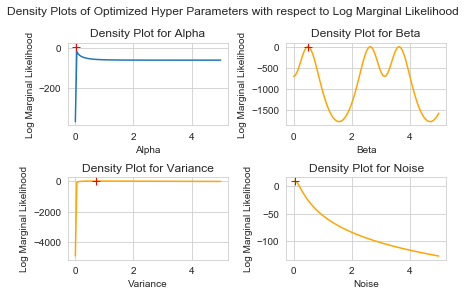

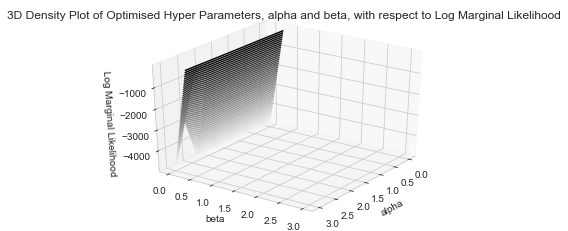

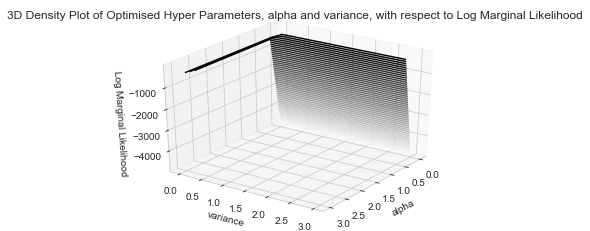

In [39]:
# 4. Optimisation Plots

# These are optional and will be expanded. 

optimisation_plot = visualisation.Visualisation_Optimiser(oscillatory = True, observed_timepoints = observed_timepoints, observed_y = cells[:,0], optimizer_result = optim)

# The first plot, using plotting_hyperparameters_densities_2d() uses the results from the optimiser.
# In turn, it fixes all other parameters using their optimum values and lets one vary with respect to the Log Marginal Likelihood.
# More on this in the docs.

optimisation_plot.plotting_hyperparameters_densities_2d()
plt.show()

# The second plot, using plotting_hyperparameters_densities_3d does the same but for a range of values of your choice.
# This time the process is done with respect to two hyperparameters, to yield a 3D plot of how certain hyperparameters vary together.
# Note: in other platforms (not jupyter notebook) the 3D plots are interactive and can be moved around much more easily.

optimisation_plot.plotting_hyperparameters_densities_3d(range = [0,3], hyperparameters = ['alpha', 'beta'])
plt.title("3D Density Plot of Optimised Hyper Parameters, alpha and beta, with respect to Log Marginal Likelihood")
plt.show()
optimisation_plot.plotting_hyperparameters_densities_3d(range = [0,3], hyperparameters = ['alpha', 'variance'])
plt.title("3D Density Plot of Optimised Hyper Parameters, alpha and variance, with respect to Log Marginal Likelihood")
plt.show()

# These are particularly uninteresting for this example but it is not always necessarily the case.

In [ ]:
# 5. Model Selection Process for all observed and control cells

# This model selection relies on the bootstrap approximation of the distribution of LLRs for a population of non-oscillating cells.
# This is then used as a frame of reference to compare our observed LLR distributions to identify both visually and analytically whether
# our sample of observed cells are behaving in an oscillatory or non-oscillatory manner. Analytically the estimation of q-values is used.
# For more information on the Model Selection process in detail I recommend checking out the documentation.

# Warning: model selection is currently the most expensive in terms of running time.
#          Selecting 200 Synthetic Cells take about 10 minutes to produce a result
#          Selecting 2000 synthetic cells take about ~1.4 hours to produce a result.
#          Whilst a larger population of Synthetic Cells give us more certainty, for this example we will keep to 200 Synthetic Cells.

modelselection = model_selection.ModelSelection()
modelselection = modelselection.model_selection_with_control(observed_timepoints = observed_timepoints, control_cells = control_cells[:,1:11], observed_cells = observed_cells[:,1:11], number_of_synthetic_cells = 200, control_q_value = 0.05, initial_guess = [start_alpha, start_beta, start_variance, start_noise])

Completed Fitting of 20 Observed Cells
Completed Generation of Synthetic Cells of Observed Cell 1
Completed Generation of Synthetic Cells of Observed Cell 2
Completed Generation of Synthetic Cells of Observed Cell 3
Completed Generation of Synthetic Cells of Observed Cell 4
Completed Generation of Synthetic Cells of Observed Cell 5
Completed Generation of Synthetic Cells of Observed Cell 6
Completed Generation of Synthetic Cells of Observed Cell 7
Completed Generation of Synthetic Cells of Observed Cell 8
Completed Generation of Synthetic Cells of Observed Cell 9
Completed Generation of Synthetic Cells of Observed Cell 10
Completed Generation of Synthetic Cells of Observed Cell 11
Completed Generation of Synthetic Cells of Observed Cell 12
Completed Generation of Synthetic Cells of Observed Cell 13
Completed Generation of Synthetic Cells of Observed Cell 14
Completed Generation of Synthetic Cells of Observed Cell 15
Completed Generation of Synthetic Cells of Observed Cell 16
Completed 